In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

image_index                                                 2349
latitiude                                                42.3334
longitude                                               -83.0489
projection                                             EPSG:2898
resolution                                            (1.0, 1.0)
metadata       {'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...
county                                                     Wayne
window_size                                                 2000
chunk_file                                                     3
Name: 26929, dtype: object

(1000, 3, 1000, 1000)



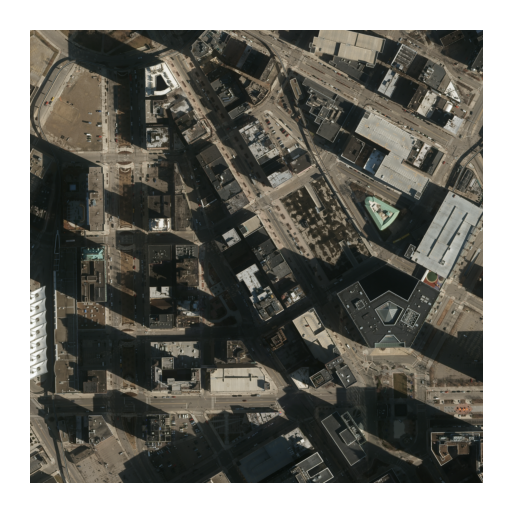

In [2]:
class Extractor():
    """A class to manage retrieval of images from stored .npy files"""

    def __init__(self, DIR_PATH='/Volumes/Cooper_TB_Drive/research/readmissions/tile_files/'):
        """ initialize demands a mapped directory """

        self.DIR_PATH = DIR_PATH
        self.coordinate_maps = {}

        # build coordinate maps
        for file in os.listdir(self.DIR_PATH):
            if 'csv' in file:
                county = file.split("_")[0]
                full_path = f"{self.DIR_PATH}{file}"
                frame = pd.read_csv(full_path)

                self.coordinate_maps[county] = frame

        self.MASTER = pd.concat(self.coordinate_maps.values(), ignore_index=True)



    def tile_getter(self, county, chunk_id):
        """ a method to retrieve a given file by county and chunk
        id.

        ARGS:   
            - county (str): name of county, must be in `self.coordinate_maps.keys()`
            - chunk_id (int or str): a valid chunk id.

        RETURNS:
            - tiles (np.array): (record, channels, x, y)
        """
        file_to_get = f"{self.DIR_PATH}{chunk_id}_{county}_tiles.npy"
        # check to make sure it's real
        assert(os.path.isfile(file_to_get))
        return np.load(file_to_get, mmap_mode='r')

    
    def find_closest_latlon(self, lat, lon):
        """A simple Euclidean distance function to find 
        closest tile given coordinates.
        
        ARGS:   
            - lat (float): query latitude
            - lon (float): query longitude

        RETURNS:
            - result (pd.Series): the record for the closest tile
        """

        tile_coords = np.array(list(zip(self.MASTER['latitiude'], 
                                        self.MASTER['longitude'])))
        search_node = (lat, lon)
        dists = np.sum((tile_coords - search_node)**2, axis=1)
        res = np.argmin(dists)
        return self.MASTER.iloc[res]
        

    def build_fig(self, title="", axis_off=False, size=(5, 5), 
              y_lab="", x_lab="", title_size=15, dpi=300):
        """A function to build a matplotlib figure. Primary
        goal is to sandardize the easy stuff.
        Args:
            - title (str): the title of the plot
            - axis_off (bool): should the axis be printed?
            - size (tuple): how big should the plot be?
            - y_lab (str): y axis label
            - x_lab (str): x axis label
        Returns:
            fig (plt.figure)
        """
        fig = plt.figure(figsize=size, 
                        facecolor='w',
                        dpi=dpi)
        fig.suptitle(title, fontsize=title_size)
        plt.xlabel(x_lab, fontsize=title_size)
        plt.ylabel(y_lab, fontsize=title_size)
        
        if axis_off:
            plt.axis('off')
        return fig

    
    def plot_image(self, img_arr):
        """A method to plot an image from a quilt section 
        
        ARGS: 
            - img_arr (np.array): expects channels first            
        """
        fig = self.build_fig(size=(2,2), axis_off=True)
        plt.imshow(np.moveaxis(img_arr, 0, 2))




extractor = Extractor()

test_query = extractor.find_closest_latlon(lat=42.331395, lon=-83.049345)
print(test_query)
print()

test_tiles = extractor.tile_getter(test_query['county'], test_query['chunk_file'])
print(test_tiles.shape)
print()

# get image
img_to_chunk_index = int(str(test_query['image_index'])[1:]) 
img = test_tiles[img_to_chunk_index, :, :, :]
extractor.plot_image(img)

In [45]:
extractor.MASTER['county'].value_counts()

Wayne         30780
Oakland        7654
Monroe         6132
Washtenaw      5964
Livingston     4830
Name: county, dtype: int64

In [46]:
extractor.MASTER['resolution'].value_counts()

(1.0, 1.0)    30780
(2.0, 2.0)    24580
Name: resolution, dtype: int64

In [43]:
extractor.MASTER.columns

Index(['image_index', 'latitiude', 'longitude', 'projection', 'resolution',
       'metadata', 'county', 'window_size', 'chunk_file'],
      dtype='object')